# Categorical and quantitative data - hyperparameter tuning - CatBoost

### Techniques covered in this Notebook
- Preprocessing the categorical and quantitative data
- CatBoost
- Hyperparameter tuning

In [2]:
import numpy as np
import pandas as pd
import csv
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import time  
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
import random
import itertools

import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Load the data

In [3]:
# Set model family name  no features excluded, PCA not applied in this version
model_family = 'Catboost'

Specify data input folder

In [4]:
# SET FOLDERS (LOCAL OR REMOTE - COLAB COVERED IN THIS CELL)

# Local folders 
data_input_folder = '../data'
output_folder = '../data/Interim'

# In case run locally, also set the 'task_type' argument in 'model_param_ranges' to the default 'CPU' (for both 'sex and 'ADHD' prediction)

# Colab 
# Mount drive 
#from google.colab import drive
#drive.mount('/content/drive')

# Set Colab folders
# data_input_folder = '/content/drive/MyDrive/WIDS_2025'
# output_folder = '/content/drive/MyDrive/WIDS_2025/Output'

# In case run on Colab, also set the 'task_type' argument in 'model_param_ranges' to 'GPU' (for both 'sex and 'ADHD' prediction)

Load training data

In [5]:
# Start runtime measurement
start_time                 = time.time()

# Load categorical data as category:
train_cat_features         = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_cat_features.sort_values(by='participant_id', inplace=True)
train_cat_features         = train_cat_features.astype('category')

# Load quantitative data:
train_quant_features       = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_quant_features.sort_values(by='participant_id', inplace=True)

# Load solutions:
solution                   = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
solution.sort_values(by='participant_id', inplace=True)
solution                   = solution.astype('category') 

# Merge datasets into one:
train_merged               = pd.merge(train_cat_features, train_quant_features, on='participant_id', how='left')
train_merged               = pd.merge(train_merged, solution, on='participant_id', how='left')

# Dictionary of training data
train                      = {'mode': 'train',
                              'cat': train_cat_features,
                              'quant': train_quant_features,
                              'solution': solution,
                              'merged': train_merged}

Load test data

In [6]:
# Load categorical data as category:
test_cat_features         = pd.read_excel(f"{data_input_folder}/TEST/TEST_CATEGORICAL.xlsx")
test_cat_features         = test_cat_features.astype('category')

# Load quantitative data:
test_quant_features       = pd.read_excel(f"{data_input_folder}/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

# Merge datasets into one:
test_merged               = pd.merge(test_cat_features, test_quant_features, on='participant_id', how='left')

# Dictionary of training data
test                      = {'mode': 'test',
                             'cat': test_cat_features,
                             'quant': test_quant_features,
                             'solution': None,
                             'merged': test_merged}

## Set parameters

Set parameters for data preprocessing

In [7]:
# Size of random sample selected from hyperparameter range
n_samples = 100

data_preproc_params = {}

# Full list of 9 categorical variables:
#   Basic_Demos_Enroll_Year, Basic_Demos_Study_Site, PreInt_Demos_Fam_Child_Ethnicity, PreInt_Demos_Fam_Child_Race,	
#   MRI_Track_Scan_Location, Barratt_Barratt_P1_Edu, Barratt_Barratt_P1_Occ,           Barratt_Barratt_P2_Edu',      Barratt_Barratt_P2_Occ

# Full list of 18 quantitatigve variables:
#   EHQ_EHQ_Total,	            ColorVision_CV_Score,  APQ_P_APQ_P_CP,	          APQ_P_APQ_P_ID,	         APQ_P_APQ_P_INV,   
#   APQ_P_APQ_P_OPD	            APQ_P_APQ_P_PM,	       APQ_P_APQ_P_PP	          SDQ_SDQ_Conduct_Problems,	 SDQ_SDQ_Difficulties_Total, 
#   SDQ_SDQ_Emotional_Problems	SDQ_SDQ_Externalizing, SDQ_SDQ_Generating_Impact, SDQ_SDQ_Hyperactivity	     SDQ_SDQ_Internalizing	
#   SDQ_SDQ_Peer_Problems,      SDQ_SDQ_Prosocial,     MRI_Track_Age_at_Scan

# Columns to drop based on explanatory data analysis (drop columns that do not seem useful):
#data_preproc_params['cat_columns_to_drop']   = ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location']
#data_preproc_params['quant_columns_to_drop'] = ['EHQ_EHQ_Total', 'APQ_P_APQ_P_CP', 'MRI_Track_Age_at_Scan']
data_preproc_params['cat_columns_to_drop']   = []
data_preproc_params['quant_columns_to_drop'] = []

# Specify if Principal Component Analysis (PCA) should be used for dimension reduction for quantitative features and connectome matrices:
# If yes specify the number of principal components
data_preproc_params['apply_pca_quant']              = False
data_preproc_params['nr_pca_components_quant']      = 4

# Set imputer methods:
data_preproc_params['categorical_imputer_strategy']          = 'most_frequent'         # Options: 'most frequent' 

data_preproc_params['numeric_imputer']                       = 'iterative'             # Options: 'iterative' or 'simple'
                                                                                       # In case 'iterative' selected then a RF regression will be performed
data_preproc_params['numeric_imputer_strategy']              = None                    # Options for simple: 'median', 'mean', 'most freqent', 'constant'
                                                                          # No options for iterative

Set model hyperparameters

In [8]:
model_param_ranges = {
    'sex': {
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
        'depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': {'min': 100, 'max': 1100, 'step': 100},
        'subsample': [0.5, 0.7, 0.9, 1.0],
        'border_count': [32, 64, 128, 254],  # Number of splits for numeric features
        'loss_function': ['Logloss'],       # Fixed parameter for binary classification
        'eval_metric': ['F1'],              # Optional: useful for F1 optimization
        'verbose': [0],                     # Fixed parameter to suppress logs
        #'task_type': ['GPU']                # Use GPU on Colab
        'task_type': ['CPU']                # Use CPU on local machi

    },

    'adhd': {
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
        'depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': {'min': 100, 'max': 1100, 'step': 100},
        'subsample': [0.5, 0.7, 0.9, 1.0],
        'border_count': [32, 64, 128, 254],  # Number of splits for numeric features
        'loss_function': ['Logloss'],       # Fixed parameter for binary classification
        'eval_metric': ['F1'],              # Optional: useful for F1 optimization
        'verbose': [0],                     # Fixed parameter to suppress logs
        #'task_type': ['GPU']                # Use GPU on Colab
        'task_type': ['CPU']                # Use CPU on local machine
    }
}


prediction_thresholds = {
    'sex': np.linspace(0, 1, 21),
    'adhd': np.linspace(0, 1, 21)
}

Set model evaluation parameters

In [9]:
# Number of folds (k) for k-fold cross-validation:
nr_of_folds      = 5 

## Data preprocessing

Define Principal Component Analysis (PCA)

In [10]:
def perform_pca(data, nr_pca_components):
    """
    Perform PCA on quantitative variables
    """

    # Extract mode
    mode = data['mode']

    # Select quantitative (numeric) data for PCA and the full merged dataset
    data_quant = data['quant'].copy()
    data_merged = data['merged'].copy()

    # Extract the ID column
    participant_id = data_quant['participant_id'].copy()

    # Select only numeric columns for PCA (excluding 'participant_id')
    data_quant = data_quant.iloc[:, 1:].copy()

    # Replace missing values by the median as otherwise PCA does not run
    data_quant.fillna(data_quant.median(), inplace=True)

    # Standardise data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_quant)

    # Apply PCA
    pca = PCA(n_components=nr_pca_components)
    data_pca = pca.fit_transform(data_scaled)

    # Set PCA column names
    pca_columns = [f"PC{i+1}" for i in range(nr_pca_components)]

    # Convert to DataFrame
    data_pca = pd.DataFrame(data_pca, columns=pca_columns)

    # Add back participant_id
    data_pca.insert(0, 'participant_id', participant_id.values)

    # Check variance explained
    explained_variance = pca.explained_variance_ratio_
    total_explained_variance = explained_variance.sum()

    print(f"Variance explained for quantitative ({mode} data): {explained_variance}")
    print(f"Total variance explained by {nr_pca_components} components for quantitative {mode} data: {total_explained_variance:.1%}")

    # Replace the original quantitative columns by the PCA columns in the merged dataset
    data_merged.drop(columns=data_quant.columns, inplace=True, errors='ignore')
    data_merged = data_merged.merge(data_pca, on='participant_id', how='left')

    # Update data dictionary
    data['merged'] = data_merged
    data['quant'] = data_pca

    return data



In [11]:
def preprocess_data(data, data_preproc_params):

    """
    Perform data preprocessing on both categorical and numerical data
    """

    # Extract mode (train or test)
    mode                    = data['mode']

    # Merge categorical and quantitative columns to drop (no columns dropped from connectome matrix):
    cat_columns_to_drop     = data_preproc_params['cat_columns_to_drop']
    quant_columns_to_drop   = data_preproc_params['quant_columns_to_drop']
    columns_to_drop         = cat_columns_to_drop + quant_columns_to_drop
    
    # Drop selected columns for categorical and quantitative data:
    data_cat                = data['cat']
    data_cat = data_cat.drop(cat_columns_to_drop, axis = 1)

    data_quant              = data['quant']
    data_quant              = data_quant.drop(quant_columns_to_drop, axis = 1)

    data_merged             = data['merged']

    # Run PCA on quantitative variables if required by the user:
    apply_pca_quant         = data_preproc_params['apply_pca_quant']
    nr_pca_components_quant = data_preproc_params['nr_pca_components_quant']

    if apply_pca_quant:
        # Perform PCA        
        data = perform_pca(data, nr_pca_components_quant)
        
        # Update quantitative and merged data
        data_quant          = data['quant']
        data_merged         = data['merged']
        

    # Add participant_id and target variables (for training data) to the list of columns to drop:
    columns_to_drop.append('participant_id')

    if mode == 'train':
        columns_to_drop.append('ADHD_Outcome')                     
        columns_to_drop.append('Sex_F')

    # Separate features and target variables
    X      = data_merged.drop(columns_to_drop, axis=1, errors='ignore')

    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

    # Specify imputer methods from data processing parameters
    numeric_imputer = data_preproc_params['numeric_imputer']
    numeric_imputer_strategy = data_preproc_params['numeric_imputer_strategy']
    categorical_imputer_strategy = data_preproc_params['categorical_imputer_strategy']

    # Simple numeric imputer
    if numeric_imputer == 'simple':
        # Create preprocessing pipelines
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy=numeric_imputer_strategy)),
            ('scaler', StandardScaler())
        ])
    else:
        numeric_transformer = Pipeline(steps=[
        ('imputer', IterativeImputer(random_state=0)),
        ('scaler', StandardScaler())
    ])


    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=categorical_imputer_strategy)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    X_preprocessed = preprocessor.fit_transform(X)

    print(f'Shape of preprocess {mode} data: ', X_preprocessed.shape)

    return X_preprocessed

Perform data preprocessing

In [12]:
X_preprocessed_train = preprocess_data(train, data_preproc_params)
X_preprocessed_test  = preprocess_data(test, data_preproc_params)

Shape of preprocess train data:  (1213, 27)
Shape of preprocess test data:  (304, 27)


## Model training

In [13]:
def train_model(X_preprocessed, nr_of_folds, model_param, target):


    # Set model:
    if target == 'adhd':
        y_actual = solution['ADHD_Outcome']
    else:
        y_actual = solution['Sex_F']

    # Calculate class weights for ADHD for LGBM and Catboost:
    weights   = compute_class_weight(class_weight='balanced', classes=np.unique(y_actual), y=y_actual)

    # Specify LGBM model with default parameters:
    model    = cb.CatBoostClassifier(
                        learning_rate = model_param[target]['learning_rate'],
                        depth = model_param[target]['depth'],
                        l2_leaf_reg = model_param[target]['l2_leaf_reg'],
                        iterations = model_param[target]['iterations'],
                        subsample = model_param[target]['subsample'],
                        border_count = model_param[target]['border_count'],
                        loss_function = model_param[target]['loss_function'],
                        eval_metric = model_param[target]['eval_metric'],
                        verbose = model_param[target]['verbose'],
                        task_type = model_param[target]['task_type'],
                        bootstrap_type = 'Bernoulli',  
                        class_weights = weights.tolist()
                    )

    # Split data into training and validation sets using k-fold cross-validation:
    X_train, X_val, y_train, y_val = train_test_split(
        X_preprocessed, y_actual, test_size = 1 / nr_of_folds, random_state=42, stratify=y_actual
        )        

    # Train model
    #print(f"Training {model_family} model for {target} prediction...")
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    #print(f"Training {model_family} for {target} completed.")
    
    return model, X_val, y_val

## Model Evaluation

Evaluate the model on the test set and calculate its accuracy.

Define weighted F1 score (evaluation metric specified in the Datathon where females have double weight for ADHD prediction)

In [14]:
def get_weighted_f1(y_true: pd.Series, y_pred: pd.Series, sex: pd.Series, female_weight: float = 2.0, male_weight: float = 1.0) -> float:

    sample_weight = np.where(sex == 1, female_weight, male_weight)
    return f1_score(y_true, y_pred, average='binary', sample_weight=sample_weight)

### Select best model (highest F1 score)

Expand parameter ranges for hypermarameter tuning (using model_param_ranges )

In [15]:
def sample_param_grid(param_dict, n_samples=n_samples, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    # Expand any param defined with min/max/step
    expanded = {}
    for key, value in param_dict.items():
        if isinstance(value, dict) and {'min', 'max', 'step'}.issubset(value.keys()):
            expanded[key] = list(range(value['min'], value['max'] + 1, value['step']))
        else:
            expanded[key] = value

    # Now sample from the full grid
    keys = list(expanded.keys())
    all_combinations = list(itertools.product(*(expanded[key] for key in keys)))
    print(f"Total possible combinations: {len(all_combinations)}")

    sampled_combinations = random.sample(all_combinations, min(n_samples, len(all_combinations)))

    # Convert list of tuples to list of dicts
    sampled_param_dicts = [dict(zip(keys, combo)) for combo in sampled_combinations]
    return sampled_param_dicts


Perform hyperparamter tuning to select the best model

In [16]:
def select_best_model(X_preprocessed_train, nr_of_folds, model_param_ranges, target, y_val_sex=None, n_samples=n_samples):
    best_metric = -1
    best_model = None
    best_params = None

    fixed_threshold = 0.5

    param_grid = sample_param_grid(model_param_ranges[target], n_samples=n_samples)

    for i, param_combo in enumerate(param_grid, start=1):
        model_params = {target: param_combo}
        model, X_val, y_val = train_model(X_preprocessed_train, nr_of_folds, model_params, target)
        
        # Use predict_proba and select the probability for the positive class (1)
        y_pred_probs = model.predict_proba(X_val)[:, 1]  # For binary classification, select column 1
        y_pred = (y_pred_probs > fixed_threshold).astype(int)  # Apply threshold to get final predictions
        y_true = np.asarray(y_val)

        if target == 'adhd':
            if y_val_sex is None:
                raise ValueError("y_val_sex must be provided for ADHD model to compute weighted F1 score.")
            metric = get_weighted_f1(y_true, y_pred, y_val_sex)
        else:
            # Ensure y_true and y_pred are both one-dimensional arrays
            metric = f1_score(y_true, y_pred)

        if metric > best_metric:
            best_metric = metric
            best_model = model
            best_params = param_combo
            best_threshold = fixed_threshold

        # Print progress and current best score every 100 combinations
        if i % 10 == 0:
            print(f"{i} parameter combinations processed for {target} model selection | Current best F1: {best_metric:.4f}")

    best_params['best_threshold'] = best_threshold

    return best_model, X_val, y_val, best_metric, best_params



Set ADHD and set models to the best ones. Note that the best F1 scores here are not the final ones as they were calculated using a prediction threshold of 0.5 (to be optimised in the following step)

In [17]:
# Train sex model first
sex_model, X_val_sex, y_val_sex, best_f1_sex, best_params_sex = select_best_model(
    X_preprocessed_train, nr_of_folds, model_param_ranges, target='sex')

# Then ADHD model
adhd_model, X_val_adhd, y_val_adhd, best_f1_adhd, best_params_adhd = select_best_model(
    X_preprocessed_train, nr_of_folds, model_param_ranges, target='adhd',
    y_val_sex=y_val_sex
)

Total possible combinations: 42240
10 parameter combinations processed for sex model selection | Current best F1: 0.5366
20 parameter combinations processed for sex model selection | Current best F1: 0.5685
30 parameter combinations processed for sex model selection | Current best F1: 0.5685
40 parameter combinations processed for sex model selection | Current best F1: 0.5685
50 parameter combinations processed for sex model selection | Current best F1: 0.5685
60 parameter combinations processed for sex model selection | Current best F1: 0.5685
70 parameter combinations processed for sex model selection | Current best F1: 0.5685
80 parameter combinations processed for sex model selection | Current best F1: 0.5685
90 parameter combinations processed for sex model selection | Current best F1: 0.5685
100 parameter combinations processed for sex model selection | Current best F1: 0.5685
Total possible combinations: 42240
10 parameter combinations processed for adhd model selection | Curren

Print interim best F1 scores (with prediction threshold = 0.5)

In [18]:
print('Best interim F1 score for ADHD - weighted with double weights for females: ', round(best_f1_adhd, 4))
print('Best interim F1 score for Sex - unweighted: ', round(best_f1_sex, 4))

Best interim F1 score for ADHD - weighted with double weights for females:  0.9123
Best interim F1 score for Sex - unweighted:  0.5685


Find best threshold for prediction:

In [19]:
def find_best_threshold(y_true, y_pred_probs, target, y_val_sex=None):
    thresholds = np.linspace(0, 1, 101)
    metrics = []

    for t in thresholds:
        y_pred = (y_pred_probs > t).astype(int)
        metric = (
            f1_score(y_true, y_pred) if target == 'sex'
            else get_weighted_f1(y_true, y_pred, y_val_sex)
        )
        metrics.append(metric)

    best_idx = np.argmax(metrics)
    return thresholds[best_idx], metrics[best_idx]


Print highest F1 scores and corresponding thresholds

ADHD

In [20]:
y_true_adhd = np.asarray(y_val_adhd)
y_pred_probs_adhd = adhd_model.predict_proba(X_val_adhd)[:, 1]
best_threshold_adhd, best_f1_score_adhd = find_best_threshold(y_true_adhd, y_pred_probs_adhd, 'adhd', y_val_sex)
print(f'For ADHD prediction the best prediction threshold is {best_threshold_adhd}')
print(f'Highest F1 score for sex with {model_family}: {round(best_f1_score_adhd, 4)}\n')
for param, value in best_params_adhd.items():
    print(f"  {param}: {value}")

For ADHD prediction the best prediction threshold is 0.49
Highest F1 score for sex with Catboost: 0.9123

  learning_rate: 0.1
  depth: 10
  l2_leaf_reg: 9
  iterations: 800
  subsample: 0.7
  border_count: 128
  loss_function: Logloss
  eval_metric: F1
  verbose: 0
  task_type: CPU
  best_threshold: 0.5


Sex

In [21]:
y_true_sex = np.asarray(y_val_sex)
y_pred_probs_sex = sex_model.predict_proba(X_val_sex)[:, 1]
best_threshold_sex, best_f1_score_sex = find_best_threshold(y_true_sex, y_pred_probs_sex, 'sex')
print(f'For sex prediction the best prediction threshold is {best_threshold_sex}')
print(f'Highest F1 score for sex with {model_family}: {round(best_f1_score_sex, 4)}]\n')
for param, value in best_params_sex.items():
    print(f"  {param}: {value}")

For sex prediction the best prediction threshold is 0.5
Highest F1 score for sex with Catboost: 0.5685]

  learning_rate: 0.001
  depth: 5
  l2_leaf_reg: 3
  iterations: 200
  subsample: 0.5
  border_count: 32
  loss_function: Logloss
  eval_metric: F1
  verbose: 0
  task_type: CPU
  best_threshold: 0.5


### Model Evaluation - ADHD (best)

Model performance (ADHD)

In [22]:
# Use predicted labels from model
y_true = y_true_adhd
y_pred_probs = y_pred_probs_adhd
y_pred = (y_pred_probs > best_threshold_adhd).astype(int)

# Flatten if needed
y_true = np.ravel(y_true)
y_pred = np.ravel(y_pred)

# Metrics 
# Note: for weighted F1, the sex target variable is used (as per competition rules, in the ADHD F1 score females have double weight)
weighted_f1 = get_weighted_f1(y_true, y_pred, y_val_sex)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Output
print("Weighted F1 score:", round(weighted_f1, 4))
print("F1 score:", round(f1, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("Accuracy:", round(accuracy, 4))

Weighted F1 score: 0.9123
F1 score: 0.8832
Precision: 0.8378
Recall: 0.9337
Accuracy: 0.8313


Confusion matrix (ADHD)

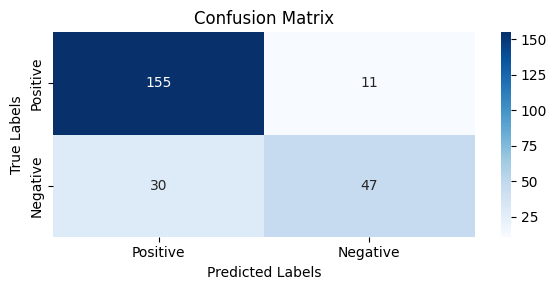

In [23]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: [TP, FN], [FP, TN] format
# If you want to follow your previous manual format:
conf_matrix = np.array([[cm[1,1], cm[1,0]],
                        [cm[0,1], cm[0,0]]])

# Plot
cm_labels = ['Positive', 'Negative']
categories = ['Positive', 'Negative']

plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=categories)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

### Model Evaluation - Sex model (best)

Model performance

In [24]:
# Use predicted labels from model
#y_true = y_val_sex.numpy() if hasattr(y_val_sex, 'numpy') else y_val_sex
y_true = y_true_sex
y_pred_probs = y_pred_probs_sex
y_pred = (y_pred_probs > best_threshold_sex).astype(int)

# Metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Output
print("F1 score:", round(f1, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("Accuracy:", round(accuracy, 4))

F1 score: 0.5685
Precision: 0.4912
Recall: 0.6747
Accuracy: 0.6502


Confusion matrix

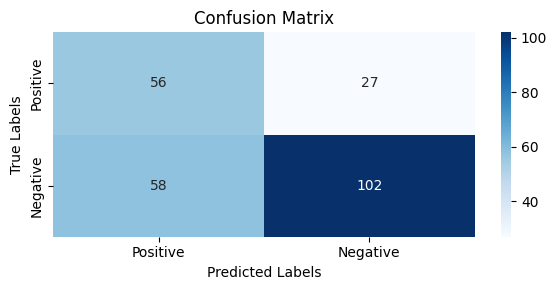

In [25]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: [TP, FN], [FP, TN] format
# If you want to follow your previous manual format:
conf_matrix = np.array([[cm[1,1], cm[1,0]],
                        [cm[0,1], cm[0,0]]])

# Plot
cm_labels = ['Positive', 'Negative']
categories = ['Positive', 'Negative']

plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=categories)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


## Prediction on the training set (for meta classification)

In [26]:
# Calculate probabilities of belonging to a certain class on the training data
y_probs_train_sex = sex_model.predict_proba(X_preprocessed_train)[:, 1]
y_probs_train_adhd = adhd_model.predict_proba(X_preprocessed_train)[:, 1]

# Use probabilities to perform model prediction on the training data
y_pred_train_sex = (y_probs_train_sex > best_threshold_sex).astype(int)
y_pred_train_adhd = (y_probs_train_adhd> best_threshold_adhd).astype(int)

# Retrieve participant id from the training data
train_cat            = train['cat']
participant_id_train = train_cat['participant_id']

Include ADHD predictins and probabilities on the trainig dataset in a pandas dataframe and save to a csv file.

In [27]:
train_pred_prob_df = pd.DataFrame({
    'participant_id': participant_id_train,  # This should be your patient_id array
    'pred_sex': y_pred_train_sex,  # Flatten the predictions (if needed)
    'prob_sex': y_probs_train_sex,  # Flatten the probabilities (if needed)
    'pred_adhd': y_pred_train_adhd,  # Flatten the predictions (if needed)
    'prob_adhd': y_probs_train_adhd  # Flatten the probabilities (if needed)
})

# Save to CSV
train_pred_prob_df.to_csv(f"{output_folder}/{model_family}_train_pred_prob.csv", index=False)

## Prediction on the test set

Evaluate model on the test data

In [28]:
# Calculate probabilities of belonging to a certain class on the training data
y_probs_test_sex = sex_model.predict_proba(X_preprocessed_test)[:, 1]
y_probs_test_adhd = adhd_model.predict_proba(X_preprocessed_test)[:, 1]

# Use probabilities to perform model prediction on the training data
y_pred_test_sex = (y_probs_test_sex > best_threshold_sex).astype(int)
y_pred_test_adhd = (y_probs_test_adhd> best_threshold_adhd).astype(int)

# Retrieve participant id from the training data
test_cat            = test['cat']
participant_id_test = test_cat['participant_id']

In [29]:
test_pred_prob_df = pd.DataFrame({
    'participant_id': participant_id_test,  # This should be your patient_id array
    'pred_sex': y_pred_test_sex,  # Flatten the predictions (if needed)
    'prob_sex': y_probs_test_sex,  # Flatten the probabilities (if needed)
    'pred_adhd': y_pred_test_adhd,  # Flatten the predictions (if needed)
    'prob_adhd': y_probs_test_adhd  # Flatten the probabilities (if needed)
})

# Save to CSV
test_pred_prob_df.to_csv(f"{output_folder}/{model_family}_test_pred_prob.csv", index=False)

Include preditions on the test dataset to a pandas dataframe and save to a submission csv file.

In [30]:
submission_cnn_adhd = pd.DataFrame({
    'participant_id': participant_id_test,  # Updated to correct test dataset patient IDs
    'ADHD_Outcome': y_pred_test_adhd,
    'Sex_F': y_pred_test_sex
})

# Save to CSV
submission_cnn_adhd.to_csv(f"{output_folder}/submission_{model_family}.csv", index=False)


In [31]:
# Print runtime
end_time = time.time()
runtime = round(end_time - start_time, 1)
print('Total runtime  is ', runtime, 'seconds')

Total runtime  is  800.7 seconds
